In [1]:
import time
import sys
import numpy as np
import wham.simdata as sim
from wham.init import Logger, update_progress, parse_command
from wham.setup import Window, startup, read_data
from wham.minim import minimization, calc_free
from wham.errors import mc_error_analysis, split_analysis, block_analysis, consistency_tests
from wham.prints import print_results, print_consistency

import scipy.optimize as optimize
import matplotlib.pyplot as plt
from operator import attrgetter

Pi = 3.14159265358979324
k_B = 0.0019872041
temp = 298.15
periodic = True
period = 360
kT = temp*k_B

In [2]:
class Simulation():
    def __init__(self, name):
        self.name = name
        self.windows = []
        self.data = []
        self.P_errors = []
        self.A_errors = []
        self.G_errors = []

In [3]:
def unbiased_potential(x, mu=180, sigma=50):
    f = -1e3 * (1/np.sqrt(2.0*Pi*sigma**2)) * np.exp(-(x-mu)**2/(2*sigma**2))
    return f

def bias_potential(coor, loc, spring):
    dx = coor - loc
    if periodic:
        dx = abs(dx)
        if dx > period/2.0:
            dx -= period
    f = 0.5 * spring * dx ** 2
    return f

def mc_step(coor, loc, spring=0.01):
    x_old = coor
    F_old = unbiased_potential(x_old) + bias_potential(x_old, loc, spring)

    trials = 0
    while trials < 100:
        trials += 1
        x_new = coor + (np.random.rand()-0.5)*20
        F_new = unbiased_potential(x_new) + bias_potential(x_new, loc, spring)
        
        a = min(1, np.exp(-(F_new - F_old)/kT))
        if np.random.rand() < a:
            return x_new
            
    return x_old

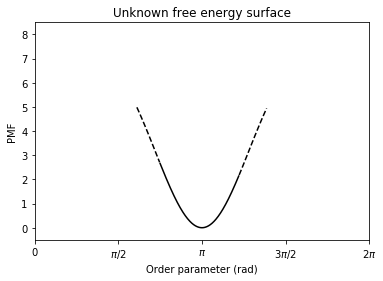

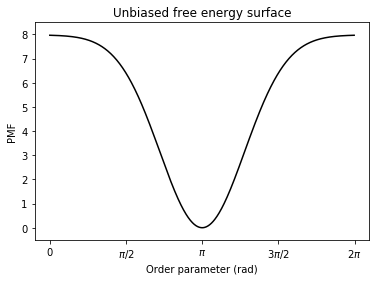

In [41]:
test = np.zeros((720,2))
test[:,0] = np.arange(0,360,0.5)
test[:,1] = unbiased_potential(test[:,0])
test[:,1] -= np.min(test[:,1])
plt.plot(test[270:440,0]*Pi/180, test[270:440,1], 'k-')
plt.plot(test[220:270,0]*Pi/180, test[220:270,1], 'k--')
plt.plot(test[440:500,0]*Pi/180, test[440:500,1], 'k--')

plt.title("Unknown free energy surface")
plt.xlabel("Order parameter (rad)")
plt.ylim([-0.5, 8.5])
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.ylabel("PMF")
plt.savefig("unknown_pmf.png", dpi=600)
plt.show()

test = np.zeros((720,2))
test[:,0] = np.arange(0,360,0.5)
test[:,1] = unbiased_potential(test[:,0])
test[:,1] -= np.min(test[:,1])
plt.plot(test[:,0]*Pi/180, test[:,1], 'k-')

plt.title("Unbiased free energy surface")
plt.xlabel("Order parameter (rad)")
plt.ylim([-0.5, 8.5])
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.ylabel("PMF")
plt.savefig("unbiased_pmf.png", dpi=600)
plt.show()

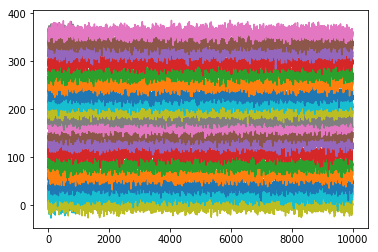

In [5]:
lengths = {"short": "100", "medium": "1000", "long": "10000"}
trajs = {"short": np.zeros((19, 100)), "medium": np.zeros((19, 1000)), "long": np.zeros((19, 10000))}

for key, val in trajs.items():
        val[:,0] = np.arange(0,380,20)

for key, data in trajs.items(): 
    for i in range(1, np.shape(data)[1]):
        for j in range(19):
            data[j,i] = mc_step(data[j,i-1], data[j,0])
        
for key, data in trajs.items():
    for i in range(19):
        plt.plot(data[i,:])
        filename = "toy_system/"+ key +"/window"+str(i)+".traj"
        outfile = open(filename, 'w')
        for j in range(len(data[i,:])):
            outfile.write("{0}\t{1}\n".format(j, data[i,j]))
        outfile.close()

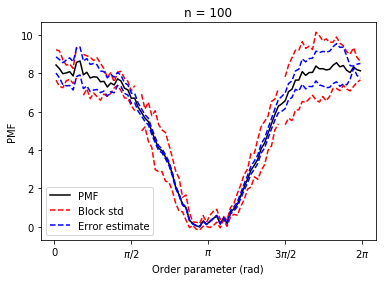

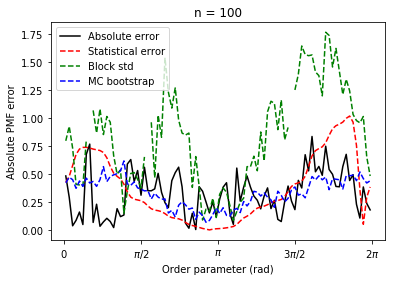

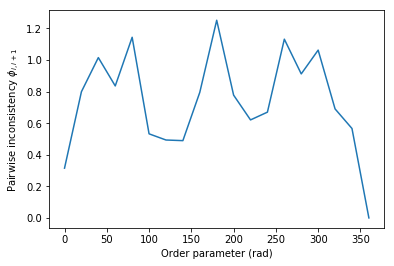

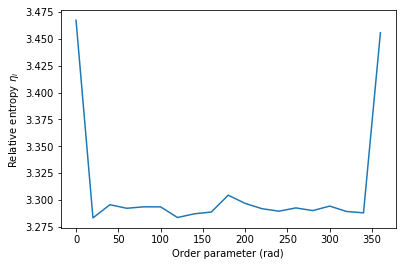

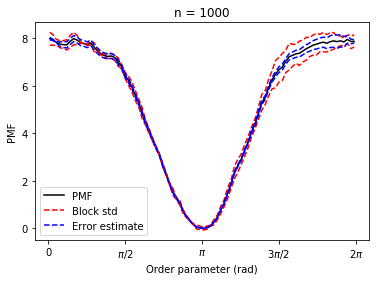

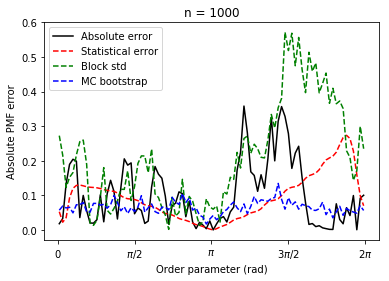

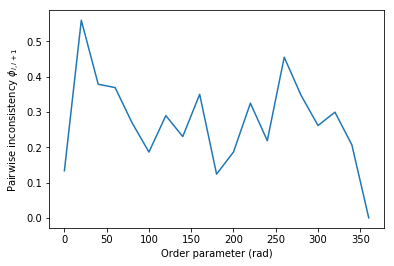

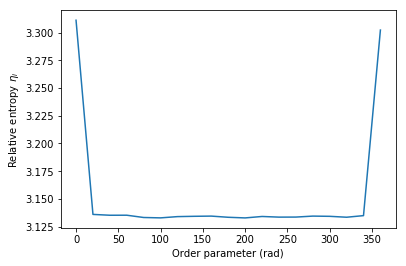

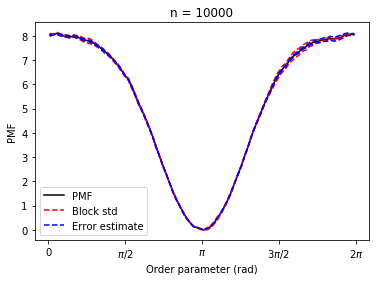

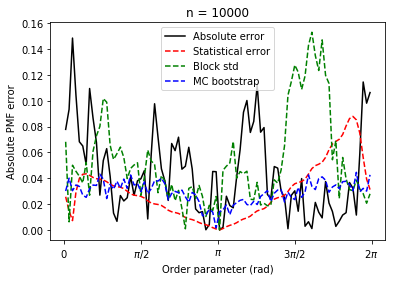

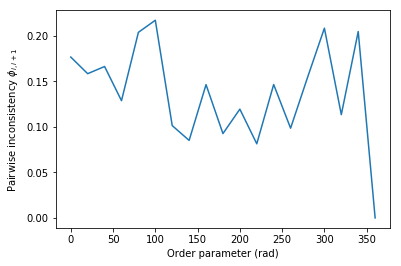

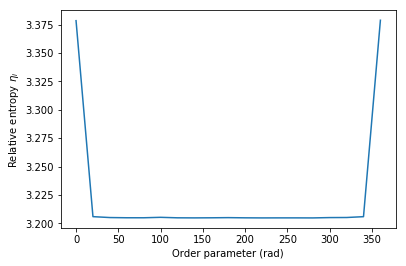

In [42]:
data = {"short": 0.0, "medium": 0.0, "long": 0.0}

simulations = []

for key in trajs:
    sys.stdout = Logger("whampy.log")
    np.seterr(all="ignore")

    metafile = "toy_system/" + key + "/toy_system.in"
    outfile = "toy_system/" + key + "/toy_system"
    
    Sim = Simulation(key)

    Sim.windows, Sim.init_time = startup(metafile)
    Sim.windows, Sim.data, read_time = read_data(Sim.windows)

    g, min_time = minimization(Sim.windows, Sim.data)
    Sim.data[:,2], Sim.data[:,3], bin_min = calc_free(g, Sim.windows, Sim.data)

    Sim.P_errors = np.zeros((sim.num_bins, 3))
    Sim.A_errors = np.zeros((sim.num_bins, 3))
    Sim.G_errors = np.zeros((sim.num_windows, 3))
    
    P_std, A_std, G_std, split_time = split_analysis(Sim.windows, Sim.data)
    P_blk, A_blk, G_blk, block_time = block_analysis(Sim.windows, Sim.data)
    P_mc, A_mc, G_mc, mc_time = mc_error_analysis(Sim.windows, Sim.data)

    Sim.P_errors[:,0] = P_std
    Sim.P_errors[:,1] = P_blk
    Sim.P_errors[:,2] = P_mc

    Sim.A_errors[:,0] = A_std
    Sim.A_errors[:,1] = A_blk
    Sim.A_errors[:,2] = A_mc
    
    Sim.G_errors[:,0] = G_std
    Sim.G_errors[:,1] = G_blk
    Sim.G_errors[:,2] = G_mc
    
    Sim.phi, Sim.eta, tests_time = consistency_tests(Sim.windows, Sim.data)

    print_results(outfile, Sim.data, A_blk, P_blk)
    print_consistency(outfile, Sim.windows, G_blk, Sim.phi, Sim.eta)

    #plt.subplot(1,3,i)
    plt.plot(Sim.data[:,0]*Pi/180.0, Sim.data[:,3], 'k-', label='PMF')
    plt.plot(Sim.data[:,0]*Pi/180.0, Sim.data[:,3]+A_std, 'r--', label='Block std')
    plt.plot(Sim.data[:,0]*Pi/180.0, Sim.data[:,3]+A_blk, 'b--', label='Error estimate')
    plt.plot(Sim.data[:,0]*Pi/180.0, Sim.data[:,3]-A_std, 'r--')
    plt.plot(Sim.data[:,0]*Pi/180.0, Sim.data[:,3]-A_blk, 'b--')
    title_text = "n = " + lengths[key]
    plt.title(title_text)
    plt.legend()
    plt.xlabel("Order parameter (rad)")
    plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    plt.ylabel("PMF")
    plt.savefig(key+"_pmf.png", dpi=600)
    plt.show()
    
    ref = unbiased_potential(Sim.data[:,0])
    ref -= np.min(ref)
    plt.plot(Sim.data[:,0]*Pi/180, abs(Sim.data[:,3]-ref), 'k-', label='Absolute error')
    plt.plot(Sim.data[:,0]*Pi/180, A_blk, 'r--', label='Statistical error')
    plt.plot(Sim.data[:,0]*Pi/180, A_std, 'g--', label='Block std')
    plt.plot(Sim.data[:,0]*Pi/180, A_mc, 'b--', label='MC bootstrap')
    plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    title_text = "n = " + lengths[key]
    plt.title(title_text)
    plt.legend()
    plt.xlabel("Order parameter (rad)")
    plt.ylabel("Absolute PMF error")
    plt.savefig(key+"_errors.png", dpi=600)
    plt.show()

    wincenters = [window.loc for window in Sim.windows]
    plt.plot(wincenters, Sim.phi)
    plt.xlabel("Order parameter (rad)")
    plt.ylabel(r'Pairwise inconsistency $\phi_{i,i+1}$')
    plt.show()

    plt.plot(wincenters, Sim.eta)
    plt.xlabel("Order parameter (rad)")
    plt.ylabel(r'Relative entropy $\eta_{i}$')
    plt.show()
    
    simulations += [Sim]

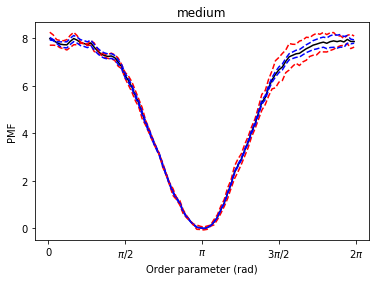

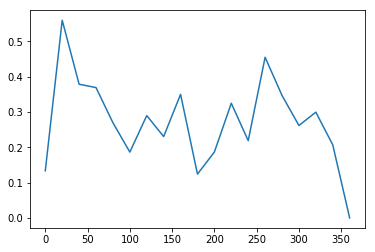

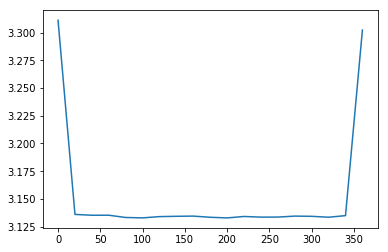

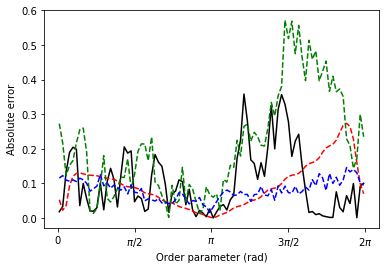

In [7]:
key = "medium"
sys.stdout = Logger("whampy.log", quiet=True)
np.seterr(all="ignore")

metafile = "toy_system/" + key + "/toy_system.in"
outfile = "toy_system/" + key + "/toy_system"
    
windows, init_time = startup(metafile)
windows, data, read_time = read_data(windows)
g, min_time = minimization(windows, data)
data[:,2], data[:,3], bin_min = calc_free(g, windows, data)

P_mc, A_mc, G_mc, mc_time = mc_error_analysis(windows, data)
P_std, A_std, G_std, split_time = split_analysis(windows, data)
P_blk, A_blk, G_blk, block_time = block_analysis(windows, data)
phi, eta, tests_time = consistency_tests(windows, data)

#print_results(outfile, data, A_std, P_std)
#print_consistency(outfile, windows, G_std, phi, eta)

#plt.subplot(1,3,i)
plt.plot(data[:,0]*Pi/180.0, data[:,3], 'k-')
plt.plot(data[:,0]*Pi/180.0, data[:,3]+A_std, 'r--')
plt.plot(data[:,0]*Pi/180.0, data[:,3]+A_blk, 'b--')
plt.plot(data[:,0]*Pi/180.0, data[:,3]-A_std, 'r--')
plt.plot(data[:,0]*Pi/180.0, data[:,3]-A_blk, 'b--')
plt.title(key)
plt.xlabel("Order parameter (rad)")
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.ylabel("PMF")
plt.show()

wincenters = [window.loc for window in windows]
plt.plot(wincenters, phi)
plt.show()

plt.plot(wincenters, eta)
plt.show()

plt.plot(data[:,0]*Pi/180, abs(data[:,3]-(unbiased_potential(data[:,0])-np.min(unbiased_potential(data[:,0])))), 'k-')
plt.plot(data[:,0]*Pi/180, A_blk, 'r--')
plt.plot(data[:,0]*Pi/180, A_std, 'g--')
plt.plot(data[:,0]*Pi/180, A_mc, 'b--')
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], ["0", r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.xlabel("Order parameter (rad)")
plt.ylabel("Absolute error")
plt.show()

In [8]:
simulations[1].windows[4].p

array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.00075, 0.004  , 0.01375, 0.02325, 0.035  , 0.052  , 0.04625,
       0.03475, 0.02175, 0.013  , 0.00425, 0.00125, 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     ])

i = 0
for key, data in trajs.items():
    i += 1
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,i)
    plt.plot(data[:,0]*Pi/180.0, data[:,3], 'k-')
    plt.plot(data[:,0]*Pi/180.0, data[:,3]+A_std, 'r--')
    plt.plot(data[:,0]*Pi/180.0, data[:,3]-A_std, 'r--')
    plt.title(key)
    plt.xlabel("Order parameter (rad)")
    plt.ylabel("PMF")

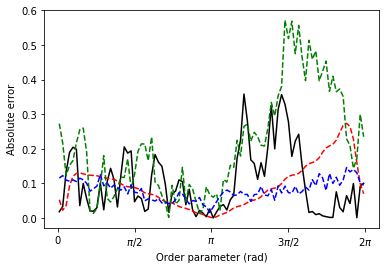

In [9]:
plt.plot(data[:,0]*Pi/180, abs(data[:,3]-(unbiased_potential(data[:,0])-np.min(unbiased_potential(data[:,0])))), 'k-')
plt.plot(data[:,0]*Pi/180, A_blk, 'r--')
plt.plot(data[:,0]*Pi/180, A_std, 'g--')
plt.plot(data[:,0]*Pi/180, A_mc, 'b--')
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], ["0", r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.xlabel("Order parameter (rad)")
plt.ylabel("Absolute error")
plt.show()

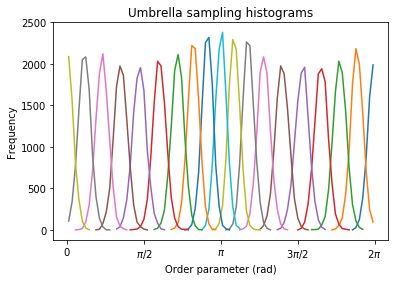

In [21]:
for window in simulations[2].windows:
    plt.plot(window.hist[:,0]*Pi/180.0, window.hist[:,1])


plt.title("Umbrella sampling histograms")
plt.xlabel("Order parameter (rad)")
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.ylabel("Frequency")
plt.savefig("us_hists.png", dpi=600)
plt.show()

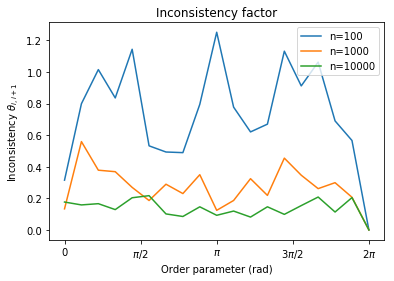

In [22]:
for Sim in simulations:
    plt.plot(np.array(wincenters)*Pi/180, Sim.phi)

plt.legend(["n=100", "n=1000", "n=10000"])
plt.title("Inconsistency factor")
plt.xlabel("Order parameter (rad)")
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.ylabel(r'Inconsistency $\theta_{i, i+1}$')
plt.savefig("inconsistency.png", dpi=600)
plt.show()

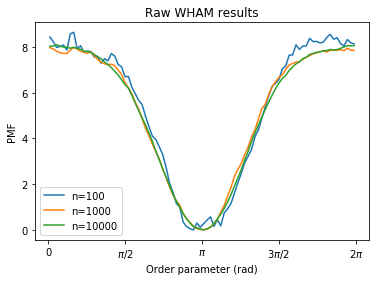

In [24]:
for Sim in simulations:
    plt.plot(Sim.data[:,0]*Pi/180, Sim.data[:,3])

plt.legend(["n=100", "n=1000", "n=10000"])
plt.title("Raw WHAM results")
plt.xlabel("Order parameter (rad)")
plt.xticks([0, Pi/2, Pi, 3*Pi/2, 2*Pi], [r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.ylabel(r'PMF')
plt.savefig("all_pmfs.png", dpi=600)
plt.show()